In [0]:
#!pip install pytorch-pretrained-bert

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from google.colab import drive   
import sklearn
# import sklearn.metrics.precision_score
# import sklearn.metrics.recall_score
# import sklearn.metrics.f1_score

import logging
logging.basicConfig(level=logging.INFO)



#from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
#!pip install bert_embedding
#from bert_embedding import BertEmbedding

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision   
#!git clone https://github.com/NVIDIA/apex
#!cd apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
#!pip install -v --no-cache-dir apex/

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def train_val_NN(neural_network, train_loader, validation_loader, loss_function, optimizer,num_epochs):
    total_step = len(train_loader)
    # initialize metric arrays
    accuracy = np.zeros(num_epochs)
    loss_np = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        for i, (comments, ratings) in enumerate(train_loader):      
            
            #print(ratings)
            ratings = ratings - torch.tensor(1)
            #print(ratings)
            #print('comments size')
            #print(comments.shape)
            #print('ratings size')
            #print(ratings.shape)
            
            comments = comments.to(device)
            ratings = ratings.to(device) 
            # Forward pass
            outputs = neural_network(comments)
            #print('outputs')
            #print(outputs.shape)
            #print(outputs)
            #print(ratings)
            loss = loss_function(outputs, ratings)
            #print(loss)
            #print(loss.shape)
            #print('---')
            
            # Backward and optimize
            # zero out the gradient so it doesn't accumulate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calculate training accuracy
        with torch.no_grad():
            correct = 0
            total = 0
        for comments, ratings in train_loader:
            comments = comments.to(device)
            ratings = ratings - torch.tensor(1)
            ratings = ratings.to(device)
            outputs = neural_network(comments)
            _, predicted = torch.max(outputs.data, 1)
            total += ratings.size(0)
            correct += (predicted == ratings).sum().item()
        accuracy[epoch] = correct / total
       
        # get loss
        loss_np[epoch] = loss.item()
        
        # calculate validation accuracy
        with torch.no_grad():
            correct = 0
            total = 0
        for comments, ratings in validation_loader:
            ratings = ratings - torch.tensor(1)

            comments = comments.to(device)
            ratings = ratings.to(device)
            outputs = neural_network(comments)
            
            _, predicted = torch.max(outputs, 1)
            
            total += ratings.size(0)
            correct += (predicted == ratings).sum().item()
        val_accuracy[epoch] = correct / total
#         val_precision[epoch] = 
#         val_recall[epoch] = 
#         val_F1[epoch] = 
        
        
        print('Epoch ' + str(epoch + 1) + ' --> Validation Accuracy: ' + str(correct/total)) 
        
    return accuracy, loss_np, val_accuracy

def test_NN(neural_network, test_loader, loss_function):
    Preds = []
    with torch.no_grad():
        for comments, ratings in test_loader:
            comments = comments.to(device)
            outputs = neural_network(comments)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted.tolist())
            Preds.extend(predicted.tolist())  
    return Preds


In [0]:
class Dataset(Dataset):
    def __init__(self, X_data, y_data):

        self.len = len(X_data)           
        if torch.cuda.is_available():
            self.x_data = torch.from_numpy(X_data).float().cuda()
            self.y_data = torch.from_numpy(y_data).long().cuda()
        else:
            self.x_data = torch.from_numpy(X_data).float()
            self.y_data = torch.from_numpy(y_data).long()
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    
# Feed Forward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        # in_features, out_features
        self.fc1 = nn.Linear(768, 5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(200, 5)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.reshape(x.size(0),-1)
        out = self.fc1(x)
        #out = self.relu(out)
        #out = self.fc2(out)
        #out = self.sigmoid(out)
        return out
    
def extract_data(x_data_filepath, y_data_filepath):
    X = np.loadtxt(x_data_filepath, delimiter=',')
    y = np.loadtxt(y_data_filepath, delimiter=',')
    return X, y   

def create_validation(x_train, y_train):
    train_size = int(0.8*len(x_train))
    inds = np.arange(len(x_train))
    S1, S2 = np.split(np.random.permutation(inds), [train_size])
    new_x_train = x_train[list(S1)]
    new_y_train = y_train[list(S1)]
    x_val = x_train[list(S2)]
    y_val = y_train[list(S2)]                                
                                        
    return new_x_train, new_y_train, x_val, y_val

In [0]:
## Extract the data
X_AmazonTrain, y_AmazonTrain = extract_data('drive/My Drive/Colab Notebooks/519project/numpy_data/AmazonTrain.out', 'drive/My Drive/Colab Notebooks/519project/numpy_data/y_AmazonTrain.out')
X_AmazonTest, y_AmazonTest = extract_data('drive/My Drive/Colab Notebooks/519project/numpy_data/AmazonTest.out', 'drive/My Drive/Colab Notebooks/519project/numpy_data/y_AmazonTest.out') 


X_TripadvisorTrain, y_TripadvisorTrain = extract_data('drive/My Drive/Colab Notebooks/519project/numpy_data/TripadvisorTrain.out', 'drive/My Drive/Colab Notebooks/519project/numpy_data/y_TripadvisorTrain.out')
X_TripadvisorTest, y_TripadvisorTest = extract_data('drive/My Drive/Colab Notebooks/519project/numpy_data/TripadvisorTest.out', 'drive/My Drive/Colab Notebooks/519project/numpy_data/y_TripadvisorTest.out') 



In [0]:
len(y_TripadvisorTrain) # 4311
len(y_TripadvisorTest) # 17,310

17310

In [0]:
## Split into training and validation sets
new_x_train, new_y_train, x_val, y_val = create_validation(X_AmazonTrain, y_AmazonTrain)
new_x_train_TRIP125, new_y_train_TRIP125, x_val_TRIP125, y_val_TRIP125 = create_validation(X_TripadvisorTrain[:125], y_TripadvisorTrain[:125])
new_x_train_TRIP625, new_y_train_TRIP625, x_val_TRIP625, y_val_TRIP625 = create_validation(X_TripadvisorTrain[:625], y_TripadvisorTrain[:625])
new_x_train_TRIP1250, new_y_train_TRIP1250, x_val_TRIP1250, y_val_TRIP1250 = create_validation(X_TripadvisorTrain[:1250], y_TripadvisorTrain[:1250])
new_x_train_TRIP2500, new_y_train_TRIP2500, x_val_TRIP2500, y_val_TRIP2500 = create_validation(X_TripadvisorTrain[:2500], y_TripadvisorTrain[:2500])
new_x_train_TRIP3750, new_y_train_TRIP3750, x_val_TRIP3750, y_val_TRIP3750 = create_validation(X_TripadvisorTrain[:3750], y_TripadvisorTrain[:3750])




## Create the data sets
train_set = Dataset(new_x_train, new_y_train)
val_set = Dataset(x_val, y_val)
test_set = Dataset(X_AmazonTest, y_AmazonTest)

## Create Tripadvisor data sets
tripadvisor125_train_set = Dataset(new_x_train_TRIP125, new_y_train_TRIP125)
tripadvisor125_val_set = Dataset(x_val_TRIP125, y_val_TRIP125)

tripadvisor625_train_set = Dataset(new_x_train_TRIP625, new_y_train_TRIP625)
tripadvisor625_val_set = Dataset(x_val_TRIP625, y_val_TRIP625)

tripadvisor1250_train_set = Dataset(new_x_train_TRIP1250, new_y_train_TRIP1250)
tripadvisor1250_val_set = Dataset(x_val_TRIP1250, y_val_TRIP1250)

tripadvisor2500_train_set = Dataset(new_x_train_TRIP2500, new_y_train_TRIP2500)
tripadvisor2500_val_set = Dataset(x_val_TRIP2500, y_val_TRIP2500)

tripadvisor3750_train_set = Dataset(new_x_train_TRIP3750, new_y_train_TRIP3750)
tripadvisor3750_val_set = Dataset(x_val_TRIP3750, y_val_TRIP3750)

tripadvisor_test_set = Dataset(X_TripadvisorTest, y_TripadvisorTest)


## Data loader
batchSize = 32
train_loader = DataLoader(dataset = train_set, batch_size = batchSize, shuffle = True)
val_loader = DataLoader(dataset = val_set, batch_size = batchSize, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batchSize, shuffle = False)

tripadvisor125_train_loader = DataLoader(dataset = tripadvisor125_train_set, batch_size = batchSize, shuffle = True)
tripadvisor125_val_loader = DataLoader(dataset = tripadvisor125_val_set, batch_size = batchSize, shuffle = True)

tripadvisor625_train_loader = DataLoader(dataset = tripadvisor625_train_set, batch_size = batchSize, shuffle = True)
tripadvisor625_val_loader = DataLoader(dataset = tripadvisor625_val_set, batch_size = batchSize, shuffle = True)

tripadvisor1250_train_loader = DataLoader(dataset = tripadvisor2500_train_set, batch_size = batchSize, shuffle = True)
tripadvisor1250_val_loader = DataLoader(dataset = tripadvisor2500_val_set, batch_size = batchSize, shuffle = True)

tripadvisor2500_train_loader = DataLoader(dataset = tripadvisor2500_train_set, batch_size = batchSize, shuffle = True)
tripadvisor2500_val_loader = DataLoader(dataset = tripadvisor2500_val_set, batch_size = batchSize, shuffle = True)

tripadvisor3750_train_loader = DataLoader(dataset = tripadvisor3750_train_set, batch_size = batchSize, shuffle = True)
tripadvisor3750_val_loader = DataLoader(dataset = tripadvisor3750_val_set, batch_size = batchSize, shuffle = True)


tripadvisor_test_loader = DataLoader(dataset = tripadvisor_test_set, batch_size = batchSize, shuffle = False)


## Model, criterion, and optimizer with default parameters
model = FeedForwardNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)  



Epoch 1 --> Validation Accuracy: 0.6500625
Epoch 2 --> Validation Accuracy: 0.6645
Epoch 3 --> Validation Accuracy: 0.6703125
Epoch 4 --> Validation Accuracy: 0.6735
Epoch 5 --> Validation Accuracy: 0.6765625
Epoch 6 --> Validation Accuracy: 0.6795
Epoch 7 --> Validation Accuracy: 0.6794375
Epoch 8 --> Validation Accuracy: 0.6810625
Epoch 9 --> Validation Accuracy: 0.6825625
Epoch 10 --> Validation Accuracy: 0.68275
Epoch 11 --> Validation Accuracy: 0.6810625
Epoch 12 --> Validation Accuracy: 0.685125
Epoch 13 --> Validation Accuracy: 0.6828125
Epoch 14 --> Validation Accuracy: 0.685
Epoch 15 --> Validation Accuracy: 0.6850625
Epoch 16 --> Validation Accuracy: 0.686875
Epoch 17 --> Validation Accuracy: 0.688375
Epoch 18 --> Validation Accuracy: 0.68825
Epoch 19 --> Validation Accuracy: 0.68825
Epoch 20 --> Validation Accuracy: 0.6890625
Epoch 21 --> Validation Accuracy: 0.689
Epoch 22 --> Validation Accuracy: 0.6878125
Epoch 23 --> Validation Accuracy: 0.68875
Epoch 24 --> Validation A

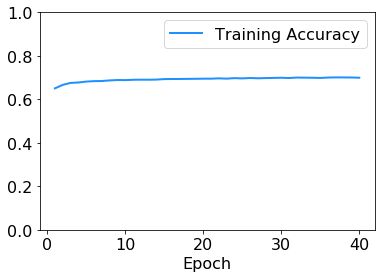

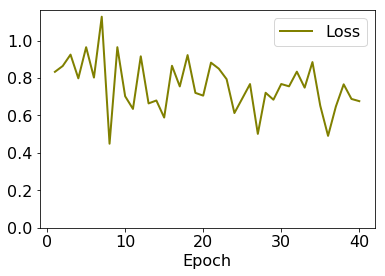

In [0]:
## Train the model
train_acc, loss, val_acc = train_val_NN(model, train_loader, val_loader, criterion, optimizer, 40)
#torch.save(model, 'drive/My Drive/Colab Notebooks/519project/model')
#train_acc, loss, val_acc = train_val_NN(model, tripadvisor125_train_loader, tripadvisor125_val_loader, criterion, optimizer, 40)
#train_acc, loss, val_acc = train_val_NN(model, tripadvisor625_train_loader, tripadvisor625_val_loader, criterion, optimizer, 40)
#train_acc, loss, val_acc = train_val_NN(model, tripadvisor2500_train_loader, tripadvisor2500_val_loader, criterion, optimizer, 40)
#train_acc, loss, val_acc = train_val_NN(model, tripadvisor3750_train_loader, tripadvisor3750_val_loader, criterion, optimizer, 40)


## Figures for report
fig = plt.figure()
x = list(np.arange(1, 41))
### Figure 1 --> Training accuracy
plt.plot( x, list(train_acc), marker='', markerfacecolor='blue', markersize=4, color='dodgerblue', linewidth=2, label='Training Accuracy')
ax = plt.gca()
ax.tick_params(axis = 'both', labelsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.ylim(0,1)
plt.legend(fontsize = 16)
## Figure 2 --> Loss
fig2 = plt.figure()
plt.plot( x, list(loss), marker='', markerfacecolor='darkolivegreen', markersize=4, color='olive', linewidth=2, label='Loss')
ax = plt.gca()
ax.tick_params(axis = 'both', labelsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.ylim(bottom=0)
plt.legend(fontsize = 16)


In [0]:
#model = torch.load('drive/My Drive/Colab Notebooks/519project/model')

In [0]:
Tripadvisor_pred = test_NN(model, tripadvisor_test_loader, criterion)
Amazon_pred = test_NN(model, test_loader, criterion)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 0, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4]
[4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4]
[4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 3, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 2, 4,

In [0]:
def numSame(x,y):
    equals = []
    for i, item in enumerate(y):
        if item == x[i]:
            equals.append(1)
        else:
            equals.append(0)
    return sum(equals)

def testAccuracy(y_predicted, y_true):
    true = y_true - 1
    true = list(true)
    same = numSame(y_predicted, true)
    total = len(true)
    acc = same/total
    return acc






def testAPRF(y_pred, y_true):
    a = testAccuracy(y_pred, y_true)
    p = precision_score(y_true, y_pred, average = 'macro')
    r = recall_score(y_true, y_pred, average = 'macro')
    f = f1_score(y_true, y_pred, average = 'macro')
    return a, p, r, f

ModuleNotFoundError: ignored

In [0]:
testAPRF(Amazon_pred, y_AmazonTest) #68%
#testAPRF(Tripadvisor_pred, y_TripadvisorTest)

NameError: ignored

In [0]:
testAPRF(Tripadvisor_pred, y_TripadvisorTest)

In [0]:
""# from sklearn.svm import SVC

# #lr2 = LogisticRegression(penalty = 'l2')
# # lr2.fit(new_x_train, new_y_train)
# # score = lr2.score(x_val, y_val)

# svm = SVC()
# svm.fit(new_x_train, new_y_train)
# score = svm.score(x_val, y_val)
hello = np.array([1,2,3,4])
hi = hello - 1
list(hi)

[0, 1, 2, 3]

In [0]:
# !pip install bert-serving-server
# !pip install bert-serving-client

# bert-serving-start -model_dir /tmp/english_L-12_H-768_A-12/ -num_worker=4 


# from bert_serving.client import BertClient
# bc = BertClient()



In [0]:
# class BertForMultiLabelSequenceClassification(PreTrainedBertModel):
#     """BERT model for classification.
#     This module is composed of the BERT model with a linear layer on top of
#     the pooled output.
#     """
#     def __init__(self, config, num_labels=5):
#         super(BertForMultiLabelSequenceClassification, self).__init__(config)
#         self.num_labels = num_labels
#         self.bert = BertModel(config)
#         self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
#         self.apply(self.init_bert_weights)

#     def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
#         _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         if labels is not None:
#             loss_fct = BCEWithLogitsLoss()
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
#             return loss
#         else:
#             return logits
        
#     def freeze_bert_encoder(self):
#         for param in self.bert.parameters():
#             param.requires_grad = False
    
#     def unfreeze_bert_encoder(self):
#         for param in self.bert.parameters():
#             param.requires_grad = True

In [0]:
# # If you want to run on GPU machine, please install `mxnet-cu92`.
# #pip install mxnet-cu92

# # Load pre-trained model tokenizer (vocabulary)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# # Tokenized input
# text = "[CLS] Grace Boatman is a cool gal [SEP]"
# tokenized_text = tokenizer.tokenize(text)

# # Mask a token that we will try to predict back with `BertForMaskedLM`
# masked_index = 5
# tokenized_text[masked_index] = '[MASK]'


# # Convert token to vocabulary indices
# indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# # Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
# #segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# # Convert inputs to PyTorch tensors
# tokens_tensor = torch.tensor([indexed_tokens])
# segments_tensors = torch.tensor([segments_ids])

In [0]:
# bert_embedding = BertEmbedding()
# bert_abstract = "Hello World Apple Bert"
# sentences = bert_abstract.split('\n')
# result = bert_embedding(sentences)
# result[0][1]

In [0]:
# # Run Baseline FeedForward

# ## Extract the data
# X, y = extract_data('drive/My Drive/Colab Notebooks/images_train.npy', 'drive/My Drive/Colab Notebooks/labels_train.npy') 
# X_test, y = extract_data('drive/My Drive/Colab Notebooks/images_test.npy', 'drive/My Drive/Colab Notebooks/labels_train.npy') 
# ## Split into training and validation sets
# new_x_train, new_y_train, x_val, y_val = create_validation(X, y)
# ## Create the data sets
# train_set = Dataset(new_x_train, new_y_train)
# val_set = Dataset(x_val, y_val)
# test_set = Dataset(X_test, new_y_train[:651])
# ## Data loader
# batchSize = 64
# train_loader = DataLoader(dataset = train_set, batch_size = batchSize, shuffle = True)
# val_loader = DataLoader(dataset = val_set, batch_size = batchSize, shuffle = True)
# test_loader = DataLoader(dataset = test_set, batch_size = batchSize, shuffle = False)
# ## Model, criterion, and optimizer with default parameters
# model = FeedForwardNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.001)  
# ## Train the model
# train_acc, loss, val_acc = train_val_NN(model, train_loader, val_loader, criterion, optimizer, 40)
# ## Figures for report
# fig = plt.figure()
# x = list(np.arange(1, 41))
# ### Figure 1 --> Training accuracy
# plt.plot( x, list(train_acc), marker='', markerfacecolor='blue', markersize=4, color='dodgerblue', linewidth=2, label='Training Accuracy')
# ax = plt.gca()
# ax.tick_params(axis = 'both', labelsize = 16)
# plt.xlabel('Epoch', fontsize = 16)
# plt.ylim(0,1)
# plt.legend(fontsize = 16)
# ## Figure 2 --> Loss
# fig2 = plt.figure()
# plt.plot( x, list(loss), marker='', markerfacecolor='darkolivegreen', markersize=4, color='olive', linewidth=2, label='Loss')
# ax = plt.gca()
# ax.tick_params(axis = 'both', labelsize = 16)
# plt.xlabel('Epoch', fontsize = 16)
# plt.ylim(bottom=0)
# plt.legend(fontsize = 16)